In [1]:
# ============================================
# 0. Imports and global settings
# ============================================
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

np.random.seed(42)

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", "{:,.4f}".format)


In [2]:
# ============================================
# 1. Load Kaggle House Prices data
# ============================================
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (1460, 81)
Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.0000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.0000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.0000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.0000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.0000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


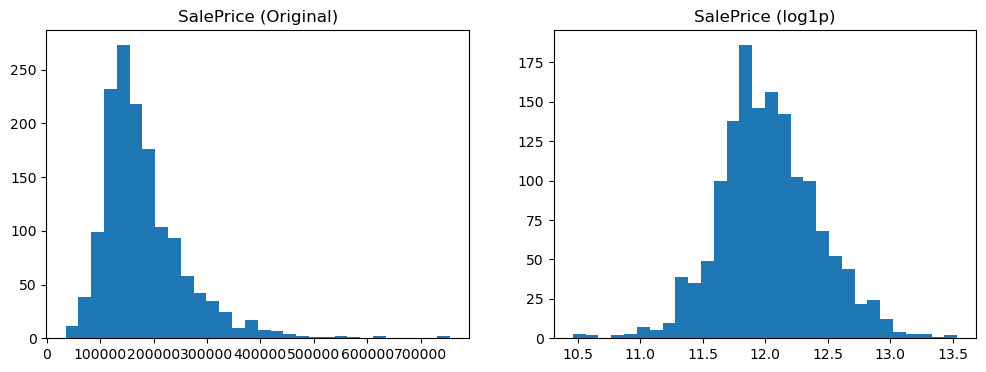

In [3]:
# ============================================
# 2. Target transformation
# ============================================
target = "SalePrice"

y = train_df[target]
y_log = np.log1p(y)
X = train_df.drop(columns=[target])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(y, bins=30)
ax[0].set_title("SalePrice (Original)")

ax[1].hist(y_log, bins=30)
ax[1].set_title("SalePrice (log1p)")
plt.show()


In [4]:
# ============================================
# 3. Feature identification & missing values
# ============================================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

missing_pct = train_df.isnull().mean().sort_values(ascending=False)
missing_pct[missing_pct > 0].head(20)


Numeric features: 37
Categorical features: 43


PoolQC         0.9952
MiscFeature    0.9630
Alley          0.9377
Fence          0.8075
MasVnrType     0.5973
FireplaceQu    0.4726
LotFrontage    0.1774
GarageYrBlt    0.0555
GarageCond     0.0555
GarageType     0.0555
GarageFinish   0.0555
GarageQual     0.0555
BsmtFinType2   0.0260
BsmtExposure   0.0260
BsmtQual       0.0253
BsmtCond       0.0253
BsmtFinType1   0.0253
MasVnrArea     0.0055
Electrical     0.0007
dtype: float64

In [5]:
# ============================================
# 4. Preprocessing
# ============================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [6]:
# ============================================
# 5. Train/validation split
# ============================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42, shuffle=True
)

X_train.shape, X_val.shape


((1168, 80), (292, 80))

In [7]:
# ============================================
# 6. Pipeline: Preprocessor + Ridge
# ============================================
ridge_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge", Ridge())
])


In [8]:
# ============================================
# 7. Ridge hyperparameter tuning
# ============================================
alpha_grid = {"ridge__alpha": [0.01, 0.1, 1, 5, 10, 20, 50, 100, 200, 300]}

ridge_cv = GridSearchCV(
    ridge_pipe,
    param_grid=alpha_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

ridge_cv.fit(X_train, y_train)

print("Best alpha:", ridge_cv.best_params_)
print("Best CV score (MSE):", -ridge_cv.best_score_)


Best alpha: {'ridge__alpha': 20}
Best CV score (MSE): 0.021965198743544016


In [9]:
# ============================================
# 8. Evaluation on validation set
# ============================================
best_ridge = ridge_cv.best_estimator_

y_val_pred_log = best_ridge.predict(X_val)

# Back-transform
y_val_true = np.expm1(y_val.values)
y_val_pred = np.expm1(y_val_pred_log)

# Metrics
mse  = mean_squared_error(y_val_true, y_val_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val_true, y_val_pred)
r2   = r2_score(y_val_true, y_val_pred)

n = len(y_val_true)
p = best_ridge.named_steps["preprocessor"].transform(X_train).shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("========================================")
print("Ridge Regression Performance (Validation)")
print("========================================")
print(f"MSE   : {mse:,.4f}")
print(f"RMSE  : {rmse:,.4f}")
print(f"MAE   : {mae:,.4f}")
print(f"R²    : {r2:,.4f}")
print(f"Adj R²: {adj_r2:,.4f}")


Ridge Regression Performance (Validation)
MSE   : 649,436,740.9764
RMSE  : 25,484.0488
MAE   : 16,610.2790
R²    : 0.9153
Adj R²: -3.9277


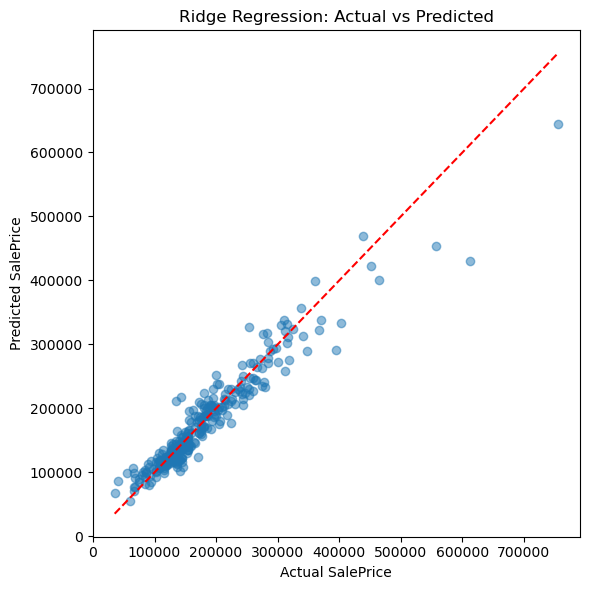

In [10]:
# ============================================
# 9. Actual vs Predicted Plot
# ============================================
plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Ridge Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()


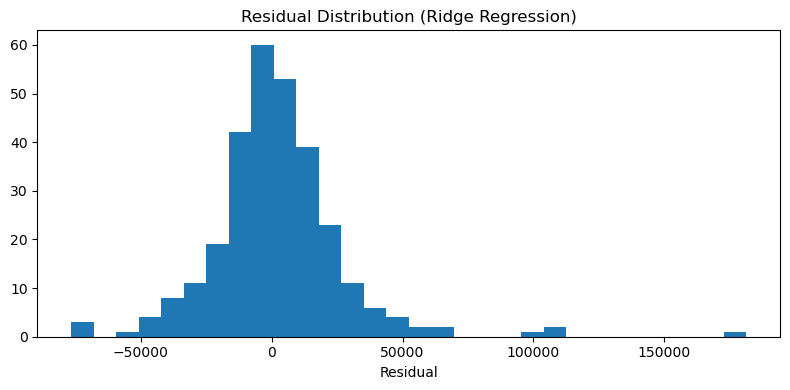

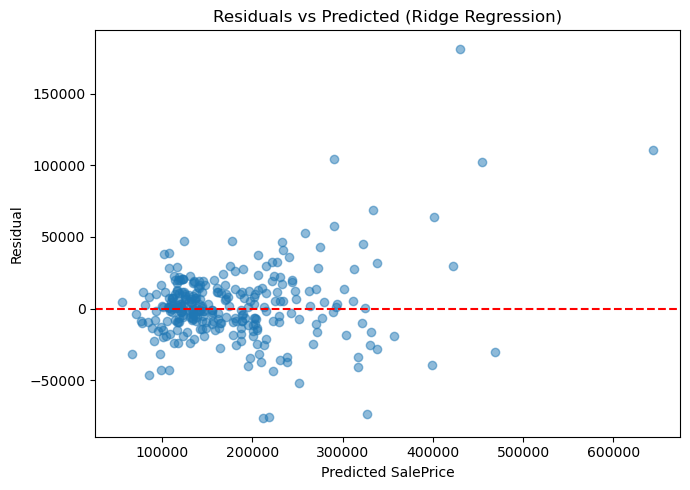

In [11]:
# ============================================
# 10. Residual diagnostics
# ============================================
residuals = y_val_true - y_val_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution (Ridge Regression)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Ridge Regression)")
plt.tight_layout()
plt.show()


In [12]:
# ============================================
# 11. Final training on FULL data
# ============================================
best_alpha = ridge_cv.best_params_["ridge__alpha"]

final_ridge = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge", Ridge(alpha=best_alpha))
])

final_ridge.fit(X, y_log)

print("Final Ridge model trained on full dataset.")


Final Ridge model trained on full dataset.


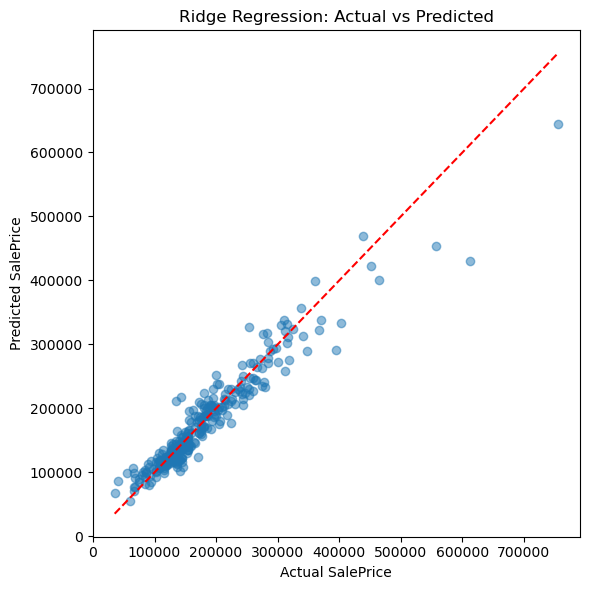

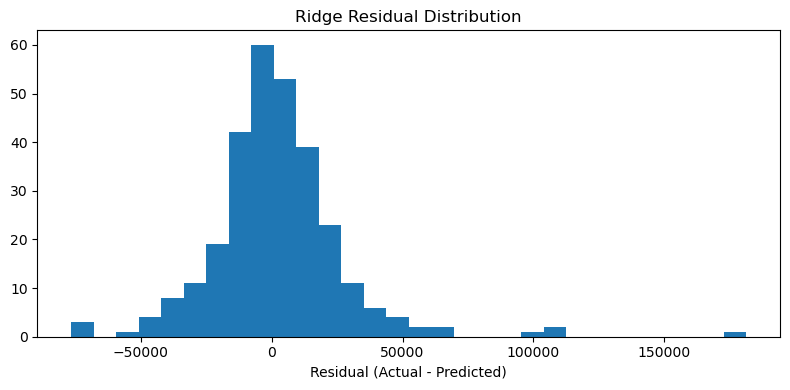

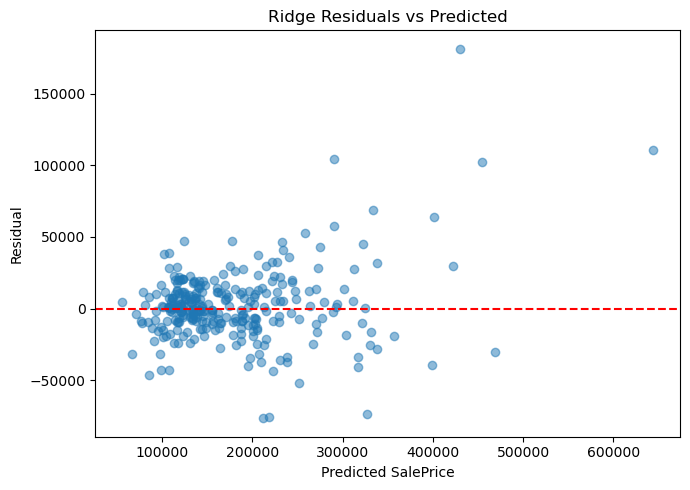

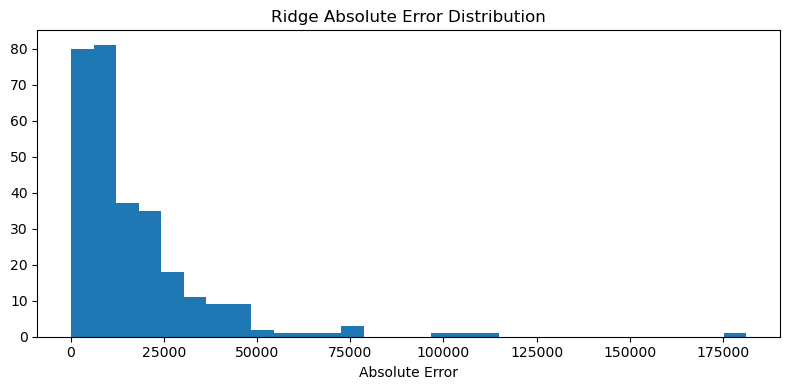

In [13]:

y_val_true_ridge = y_val_true     
y_val_pred_ridge = y_val_pred 
# ============================================
# PLOT 1 — ACTUAL vs PREDICTED
# ============================================
plt.figure(figsize=(6,6))
plt.scatter(y_val_true_ridge, y_val_pred_ridge, alpha=0.5)
min_val = min(y_val_true_ridge.min(), y_val_pred_ridge.min())
max_val = max(y_val_true_ridge.max(), y_val_pred_ridge.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Ridge Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()


# ============================================
# PLOT 2 — RESIDUAL DISTRIBUTION
# ============================================
ridge_residuals = y_val_true_ridge - y_val_pred_ridge

plt.figure(figsize=(8,4))
plt.hist(ridge_residuals, bins=30)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Ridge Residual Distribution")
plt.tight_layout()
plt.show()


# ============================================
# PLOT 3 — RESIDUALS vs PREDICTED
# ============================================
plt.figure(figsize=(7,5))
plt.scatter(y_val_pred_ridge, ridge_residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Ridge Residuals vs Predicted")
plt.tight_layout()
plt.show()


# ============================================
# PLOT 4 — ABSOLUTE ERROR HISTOGRAM
# ============================================
ridge_abs_error = np.abs(ridge_residuals)

plt.figure(figsize=(8,4))
plt.hist(ridge_abs_error, bins=30)
plt.xlabel("Absolute Error")
plt.title("Ridge Absolute Error Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# FINAL RIDGE REGRESSION METRICS
# ============================================

X_val_trans_full = preprocessor.transform(X_val)

y_val_pred_log_ridge = final_ridge.named_steps["ridge"].predict(X_val_trans_full)

y_val_true_ridge = np.expm1(y_val.values)
y_val_pred_ridge = np.expm1(y_val_pred_log_ridge)

mse_ridge  = mean_squared_error(y_val_true_ridge, y_val_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge  = mean_absolute_error(y_val_true_ridge, y_val_pred_ridge)
r2_ridge   = r2_score(y_val_true_ridge, y_val_pred_ridge)

print("===================================")
print(" FINAL RIDGE REGRESSION PERFORMANCE ")
print("===================================")
print(f"MSE  : {mse_ridge:,.4f}")
print(f"RMSE : {rmse_ridge:,.4f}")
print(f"MAE  : {mae_ridge:,.4f}")
print(f"R²   : {r2_ridge:,.4f}")


 FINAL RIDGE REGRESSION PERFORMANCE 
MSE  : 499,570,453.3298
RMSE : 22,351.0728
MAE  : 14,556.0640
R²   : 0.9349


Exception ignored in: <function ResourceTracker.__del__ at 0x107c7f2e0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1062632e0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__